In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchaudio

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyaudio
p = pyaudio.PyAudio()

FORMAT = pyaudio.paInt16
#RATE = 22050
RATE = 16000
CHUNK = 1024
CHANNELS = 1

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

RECORD_SECONDS = 5
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
  data = stream.read(CHUNK)
  frames.append(data)

stream.stop_stream()
stream.close()
p.terminate()

In [4]:
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                output=True,
                frames_per_buffer=CHUNK)
for f in frames:
  stream.write(f)
stream.close()
p.terminate()

(79872,)
torch.Size([1, 80, 313])


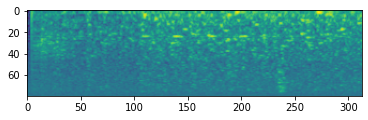

In [43]:
waveform = np.frombuffer(b''.join(frames), np.int16)/32768
print(waveform.shape)

import torch
import torchaudio
transform = torchaudio.transforms.MelSpectrogram(22050, n_fft=1024, win_length=1024, hop_length=256, n_mels=80)
mel_specgram = transform(torch.tensor(waveform[None]).type(torch.float32))
print(mel_specgram.shape)
imshow(np.log10(mel_specgram[0]))

In [6]:
from model import Rec
import torch
model = Rec()
vals = torch.load('pretrained/tinyvoice_1652627131_165_0.11.pt', map_location=torch.device('cpu'))
model.load_state_dict({k[7:]:v for k,v in vals.items()})

<All keys matched successfully>

In [85]:
mel_transform = {}
def load_example(x):
  import torchaudio
  waveform, sample_rate = torchaudio.load(x, normalize=True)
  if sample_rate not in mel_transform:
    # We extracted 80-channel filterbanks features computed from a 25ms window with a stride of 10ms.
    hop_length = int(sample_rate/(1000/10))
    win_length = int(sample_rate/(1000/25))
    mel_transform[sample_rate] = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=win_length, win_length=win_length, hop_length=hop_length, n_mels=80)
  mel_specgram = mel_transform[sample_rate](waveform)
  return mel_specgram[0].T
  #return torch.log10(mel_specgram[0].T)
CHARSET = " abcdefghijklmnopqrstuvwxyz,.'"
import itertools
def to_text(x):
  x = [k for k, g in itertools.groupby(x)]
  print(x)
  return ''.join([CHARSET[c-1] for c in x if c != 0])

In [93]:
CHARSET[19]

's'

torch.Size([1, 953, 80])
torch.Size([237, 1, 30])
tensor([ 0, 14,  2, 15,  0, 26,  0,  1,  1, 20, 20, 21, 16, 19,  0, 10,  6,  6,
        20, 20,  1, 24,  6, 19,  6,  6,  1, 10, 15,  0,  1,  0,  4, 10, 19,  0,
         4, 22, 22,  0, 13,  0,  2, 21,  0, 10, 16, 15,  0,  1,  1,  2, 21,  1,
        21,  9,  6,  1,  1, 21, 10, 14,  6,  1,  1, 16,  7,  1,  7,  2, 22, 15,
        15, 21, 13, 13,  6, 19, 19, 16, 16, 26, 26,  0,  0,  0, 20, 20, 20,  1,
         1, 21, 19,  0, 10,  2,  2, 13,  0,  0,  0,  0,  0,  0,  1, 24, 24, 10,
        21,  9,  0,  0,  1,  1, 19,  6,  6,  8,  0,  2, 19,  0,  5,  0,  1,  1,
        21, 16,  1,  1,  9, 10, 20,  0,  1,  1,  7,  0, 16, 19, 19,  0,  8,  0,
         6, 19, 19,  0, 10,  6,  6, 20, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  1,  0, 10, 21,  0,  1,  1, 24,  2, 20,  1,  1, 20,  0,
         2, 10,  5,  1, 21,  9,  2, 21, 21,  1,  0,  9,  6,  0,  1,  1,  9,  2,
         5,  0,  0,  1,  1,  3, 26,  0,  1,  0, 14,  6,  2,  2, 15,  0

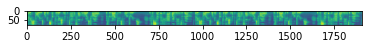

In [87]:

model.eval()
val = load_example("E:\data\LJSpeech-1.1\wavs\LJ011-0002.wav")
fake_val = mel_specgram[0].T
imshow(torch.concat([torch.log10(val).T, torch.log10(val).T], axis=1))
print(val[None].shape)
mguess = model(val[None], torch.tensor([val.shape[0]]))[0]
print(mguess.shape)
print(mguess[:, 0, :].argmax(dim=1))
pp = to_text(mguess[:, 0, :].argmax(dim=1).cpu().numpy())
print(pp)

In [30]:
sample_rate = 22050
waveform, sample_rate = torchaudio.load("E:\data\LJSpeech-1.1\wavs\LJ037-0171.wav")
mel_specgram = transform(torch.tensor(waveform[None]).type(torch.float32))
spec = mel_specgram[0].T

<ipython-input-30-7fda88dfc878>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_specgram = transform(torch.tensor(waveform[None]).type(torch.float32))
<ipython-input-30-7fda88dfc878>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2985.)
  spec = mel_specgram[0].T


In [37]:
spec[0].shape

torch.Size([80, 1])

In [39]:
model(spec[0], torch.tensor([fake_val.shape[0]]))

RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 80, 1, 1] to have 1 channels, but got 80 channels instead